# Notebook Prediction Stock Market

In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-23 00:00:00-04:00,5834.500000,5834.850098,5762.410156,5797.419922,3532650000,0.0,0.0
2024-10-24 00:00:00-04:00,5817.799805,5817.799805,5784.919922,5809.859863,3543030000,0.0,0.0
2024-10-25 00:00:00-04:00,5826.750000,5862.819824,5799.979980,5808.120117,3501280000,0.0,0.0


In [5]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-10-16 00:00:00-04:00', '2024-10-17 00:00:00-04:00',
               '2024-10-18 00:00:00-04:00', '2024-10-21 00:00:00-04:00',
               '2024-10-22 00:00:00-04:00', '2024-10-23 00:00:00-04:00',
               '2024-10-24 00:00:00-04:00', '2024-10-25 00:00:00-04:00',
               '2024-10-28 00:00:00-04:00', '2024-10-29 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24324, freq=None)

<Axes: xlabel='Date'>

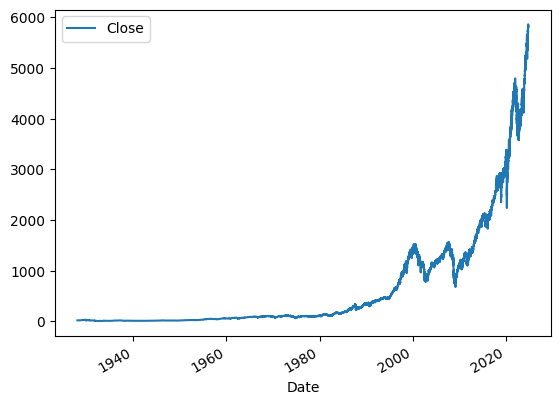

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6666666666666666

<Axes: xlabel='Date'>

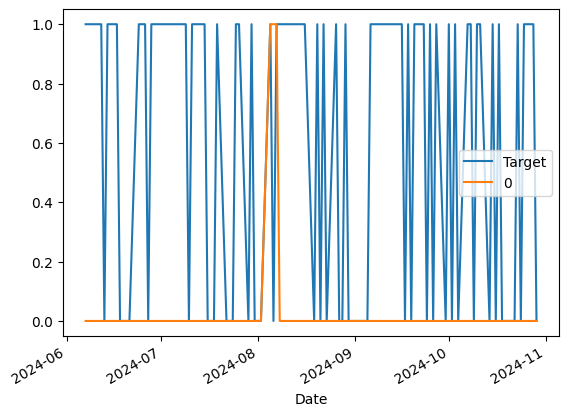

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [15]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictors = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i + step].copy()
        predictions = predict(train, test, predictors, model)
        all_predictors.append(predictions)
    return pd.concat(all_predictors)

In [16]:
predictions = backtest(sp500, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

0    3657
1    2617
Name: Predictions, dtype: int64

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288498280473825

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.535703
0    0.464297
Name: Target, dtype: float64

In [20]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_average = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_average["Close"]

    trend_column = f"Close_Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [21]:
sp500 = sp500.dropna()

In [22]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Close_Trend_2,Close_Ratio_5,Close_Trend_5,Close_Ratio_60,Close_Trend_60,Close_Ratio_250,Close_Trend_250,Close_Ratio_1000,Close_Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22 00:00:00-04:00,5832.700195,5863.040039,5821.169922,5851.200195,3342080000,5797.419922,0,0.999763,0.0,1.000076,2.0,1.043190,34.0,1.133373,148.0,1.325421,528.0
2024-10-23 00:00:00-04:00,5834.500000,5834.850098,5762.410156,5797.419922,3532650000,5809.859863,1,0.995383,0.0,0.992412,1.0,1.032494,34.0,1.121556,148.0,1.312488,528.0
2024-10-24 00:00:00-04:00,5817.799805,5817.799805,5784.919922,5809.859863,3543030000,5808.120117,0,1.001072,1.0,0.995619,2.0,1.033827,34.0,1.122509,149.0,1.314560,528.0


In [23]:
model = RandomForestClassifier(
    n_estimators=200, min_samples_split=50, random_state=1)

In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [25]:
predictions = backtest(sp500, model, predictors=new_predictors)

In [26]:
predictions["Predictions"].value_counts()

0.0    4424
1.0     849
Name: Predictions, dtype: int64

In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.574793875147232

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.54542
0    0.45458
Name: Target, dtype: float64

In [29]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-10-22 00:00:00-04:00,0,0.0
2024-10-23 00:00:00-04:00,1,0.0
2024-10-24 00:00:00-04:00,0,0.0
